# Agents with Memory

We have an email assistant that uses a router to triage emails and then passes the email to the agent for response generation. We've also evaluated it and added human-in-the-loop (HITL) to review specific tool calls. Now, we add memory, giving our assistant the ability to remember our HITL feedback!

![overview-img](img/overview_memory.png)

#### Load Environment Variables

In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

## Memory in LangGraph

### Thread-Scoped and Across-Thread Memory

First, it's worth explaining how [memory works in LangGraph](https://langchain-ai.github.io/langgraph/concepts/memory/). LangGraph offers two distinct types of memory that serve complementary purposes:

**Thread-Scoped Memory (Short-term)** operates within the boundaries of a single conversation thread. It's automatically managed as part of the graph's state and persisted through thread-scoped checkpoints. This memory type retains conversation history, uploaded files, retrieved documents, and other artifacts generated during the interaction. Think of it as the working memory that maintains context within one specific conversation, allowing the agent to reference earlier messages or actions without starting from scratch each time.

**Across-Thread Memory (Long-term)** extends beyond individual conversations, creating a persistent knowledge base that spans multiple sessions. This memory is stored as JSON documents in a memory store, organized by namespaces (like folders) and distinct keys (like filenames). Unlike thread-scoped memory, this information persists even after conversations end, enabling the system to recall user preferences, past decisions, and accumulated knowledge. This is what allows an agent to truly learn and adapt over time, rather than treating each interaction as isolated.

![short-vs-long-term-memory](img/short-vs-long.png)

The [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) is the foundation of this architecture, providing a flexible database where memories can be organized, retrieved, and updated. What makes this approach powerful is that regardless of which memory type you're working with, the same Store interface provides consistent access patterns. This allows your agent's code to remain unchanged whether you're using a simple in-memory implementation during development or a production-grade database in deployment. 

### LangGraph Store

LangGraph offers different [Store implementations](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) depending on your [deployment](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options):

1. **In-Memory (e.g., notebooks)**:
   - Uses `from langgraph.store.memory import InMemoryStore`
   - Purely a Python dictionary in memory with no persistence
   - Data is lost when the process terminates
   - Useful for quick experiments and testing
   - Semantic search can be configured as shown [here](https://langchain-ai.github.io/langgraph/how-tos/memory/semantic-search/)

2. **Local Development with `langgraph dev`**:
   - Similar to InMemoryStore but with pseudo-persistence
   - Data is pickled to the local filesystem between restarts
   - Lightweight and fast, no need for external databases
   - Semantic search can be configured as shown [here](https://langchain-ai.github.io/langgraph/cloud/deployment/semantic_search/)
   - Great for development but not designed for production use

3. **LangGraph Platform or Production Deployments**:
   - Uses PostgreSQL with pgvector for production-grade persistence
   - Fully persistent data storage with reliable backups
   - Scalable for larger datasets
   - Semantic search can be configured as shown [here](https://langchain-ai.github.io/langgraph/cloud/deployment/semantic_search/)
   - Default distance metric is cosine similarity (customizable)

Let's use the `InMemoryStore` here in the notebook! 

In [2]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

Memories are namespaced by a tuple, which in this specific example will be (`<user_id>`, "memories"). The namespace can be any length and represent anything, it does not have to be user specific.

In [3]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

We use the `store.put` method to save memories to our namespace in the store. When we do this, we specify the namespace, as defined above, and a key-value pair for the memory: the key is simply a unique identifier for the memory (memory_id) and the value (a dictionary) is the memory itself.

In [4]:
import uuid
memory_id = str(uuid.uuid4())
memory = {"food_preference" : "I like pizza"}
in_memory_store.put(namespace_for_memory, memory_id, memory)

We can read out memories in our namespace using the `store.search` method, which will return all memories for a given user as a list. The most recent memory is the last in the list. Each memory type is a Python class (`Item`) with certain attributes. We can access it as a dictionary by converting via `.dict`. The attributes it has are shown below, but the most important one is typically `value`.

In [5]:
memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '487344a0-f2b9-403a-822a-9cb32deb4f12',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-12-04T11:07:18.375297+00:00',
 'updated_at': '2025-12-04T11:07:18.375299+00:00',
 'score': None}

To use this in a graph, all we need to do is compile the graph with the store:

In [6]:
# We need this because we want to enable threads (conversations)
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
# We need this because we want to enable across-thread memory
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()
# Compile the graph with the checkpointer and store
# graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)

The store is then accessible in any node of the graph, as we'll see below!

## Adding Memory to our Assistant

Let's take our graph with HITL and add memory to it. This will be very similar to what we had previously. We'll simply update memory in the store when we get feedback from the user.

![overview-img](img/HITL_flow_memory.png)

In [7]:

%load_ext autoreload
%autoreload 2

from typing import Literal
from datetime import datetime
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.store.base import BaseStore
from langgraph.types import interrupt, Command

from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl_memory, default_triage_instructions, default_background, default_response_preferences, default_cal_preferences, MEMORY_UPDATE_INSTRUCTIONS, MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT
from email_assistant.tools.default.prompt_templates import HITL_MEMORY_TOOLS_PROMPT
from email_assistant.schemas import State, RouterSchema, StateInput
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

# Agent tools 
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Question(BaseModel):
      """Question to ask user."""
      content: str

@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool
    
# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

# Initialize the LLM, enforcing tool use (of any available tools) for agent
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="required")

Now, this is the critical part! We currently don't capture any feedback from the user in our graph. 

### Memory Management 

What we *want* to do is fairly straightforward: we want to add the feedback to the memory `Store`. If we compile our graph with the `Store`, we can access it in any node. So that is not a problem! 

But we have to answer two questions: 

1) how do we want the memory to be structured?
2) how do we want to update the memory?

For 1) we'll just store memories as string to keep things simple. In the below function, we'll just fetch memories from the store as string and initialize with default if it doesn't exist.

In [8]:
from rich.markdown import Markdown
Markdown(default_triage_instructions)

Emails that are not worth responding to:                                                                           

 • Marketing newsletters and promotional emails                                                                    
 • Spam or suspicious emails                                                                                       
 • CC'd on FYI threads with no direct questions                                                                    

There are also other things that should be known about, but don't require an email response. For these, you should 
notify (using the notify response). Examples of this include:                                                      

 • Team member out sick or on vacation                                                                             
 • Build system notifications or deployments                                                                       
 • Project status updates without action items                                                                     
 • Important company announcements                                                                                 
 • FYI emails that contain relevant information for current projects                                               
 • HR Department deadline reminders                                                                                
 • Subscription status / renewal reminders                                                                         
 • GitHub notifications                                                                                            

Emails that are worth responding to:                                                                               

 • Direct questions from team members requiring expertise                                                          
 • Meeting requests requiring confirmation                                                                         
 • Critical bug reports related to team's projects                                                                 
 • Requests from management requiring acknowledgment                                                               
 • Client inquiries about project status or features                                                               
 • Technical questions about documentation, code, or APIs (especially questions about missing endpoints or         
   features)                                                                                                       
 • Personal reminders related to family (wife / daughter)                                                          
 • Personal reminder related to self-care (doctor appointments, etc)

In [9]:
Markdown(default_cal_preferences)

30 minute meetings are preferred, but 15 minute meetings are also acceptable.

In [10]:
Markdown(default_response_preferences)        

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and  
reference the deadline in your response.                                                                           

When responding to technical questions that require investigation:                                                 

 • Clearly state whether you will investigate or who you will ask                                                  
 • Provide an estimated timeline for when you'll have more information or complete the task                        

When responding to event or conference invitations:                                                                

 • Always acknowledge any mentioned deadlines (particularly registration deadlines)                                
 • If workshops or specific topics are mentioned, ask for more specific details about them                         
 • If discounts (group or early bird) are mentioned, explicitly request information about them                     
 • Don't commit                                                                                                    

When responding to collaboration or project-related requests:                                                      

 • Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)                          
 • Explicitly mention reviewing these materials before or during the meeting                                       
 • When scheduling meetings, clearly state the specific day, date, and time proposed                               

When responding to meeting scheduling requests:                                                                    

 • If times are proposed, verify calendar availability for all time slots mentioned in the original email and then 
   commit to one of the proposed times based on your availability by scheduling the meeting. Or, say you can't make
   it at the time proposed.                                                                                        
 • If no times are proposed, then check your calendar for availability and propose multiple time options when      
   available instead of selecting just one.                                                                        
 • Mention the meeting duration in your response to confirm you've noted it correctly.                             
 • Reference the meeting's purpose in your response.

In [11]:
def get_memory(store, namespace, default_content=None):
    """Get memory from the store or initialize with default if it doesn't exist.
    
    Args:
        store: LangGraph BaseStore instance to search for existing memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        default_content: Default content to use if memory doesn't exist
        
    Returns:
        str: The content of the memory profile, either from existing memory or the default
    """
    # Search for existing memory with namespace and key
    user_preferences = store.get(namespace, "user_preferences")
    
    # If memory exists, return its content (the value)
    if user_preferences:
        return user_preferences.value
    
    # If memory doesn't exist, add it to the store and return the default content
    else:
        # Namespace, key, value
        store.put(namespace, "user_preferences", default_content)
        user_preferences = default_content
    
    # Return the default content
    return user_preferences 

For 2) updating memory, we can use a few tricks from the [GPT-4.1 prompting guide]((https://cookbook.openai.com/examples/gpt4-1_prompting_guide)) to help us update the memory: 

* For optimal performance, repeat the key instructions at the start and end of the prompt
* Create clear, explicit instructions 
* Use XML delimiters for structure
* Provide examples 

In [12]:

Markdown(MEMORY_UPDATE_INSTRUCTIONS)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                               Role and Objective                                                ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

You are a memory profile manager for an email assistant agent that selectively updates user preferences based on   
feedback messages from human-in-the-loop interactions with the email assistant.                                    

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Instructions                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

 • NEVER overwrite the entire memory profile                                                                       
 • ONLY make targeted additions of new information                                                                 
 • ONLY update specific facts that are directly contradicted by feedback messages                                  
 • PRESERVE all other existing information in the profile                                                          
 • Format the profile consistently with the original style                                                         
 • Generate the profile as a string                                                                                

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                 Reasoning Steps                                                 ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

 1 Analyze the current memory profile structure and content                                                        
 2 Review feedback messages from human-in-the-loop interactions                                                    
 3 Extract relevant user preferences from these feedback messages (such as edits to emails/calendar invites,       
   explicit feedback on assistant performance, user decisions to ignore certain emails)                            
 4 Compare new information against existing profile                                                                
 5 Identify only specific facts to add or update                                                                   
 6 Preserve all other existing information                                                                         
 7 Output the complete updated profile                                                                             

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                     Example                                                     ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

<memory_profile> RESPOND:                                                                                          

 • wife                                                                                                            
 • specific questions                                                                                              
 • system admin notifications NOTIFY:                                                                              
 • meeting invites IGNORE:                                                                                         
 • marketing emails                                                                                                
 • company-wide announcements                   

In [13]:
Markdown(MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT)

Remember:                                                                                                          

 • NEVER overwrite the entire memory profile                                                                       
 • ONLY make targeted additions of new information                                                                 
 • ONLY update specific facts that are directly contradicted by feedback messages                                  
 • PRESERVE all other existing information in the profile                                                          
 • Format the profile consistently with the original style                                                         
 • Generate the profile as a string

In [14]:
class UserPreferences(BaseModel):
    """Updated user preferences based on user's feedback."""
    chain_of_thought: str = Field(description="Reasoning about which user preferences need to add / update if required")
    user_preferences: str = Field(description="Updated user preferences")

def update_memory(store, namespace, messages):
    """Update memory profile in the store.
    
    Args:
        store: LangGraph BaseStore instance to update memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        messages: List of messages to update the memory with
    """

    # Get the existing memory
    user_preferences = store.get(namespace, "user_preferences")

    # Update the memory
    llm = init_chat_model("openai:gpt-4.1", temperature=0.0).with_structured_output(UserPreferences)
    result = llm.invoke(
        [
            {"role": "system", "content": MEMORY_UPDATE_INSTRUCTIONS.format(current_profile=user_preferences.value, namespace=namespace)},
        ] + messages
    )
    
    # Save the updated memory to the store
    store.put(namespace, "user_preferences", result.user_preferences)

We set up the triage router as we had before, with one small change

In [15]:
def triage_router(state: State, store: BaseStore) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Search for existing triage_preferences memory
    triage_instructions = get_memory(store, ("email_assistant", "triage_preferences"), default_triage_instructions)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=triage_instructions,
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
        
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

        # Next node
        goto = END
        # Update the state
        update = {
            "   ": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 

        # Next node
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    
    return Command(goto=goto, update=update)


We only need to make a small change to the interrupt handler to update the memory when the user provides feedback. 

In [16]:
def triage_interrupt_handler(state: State, store: BaseStore) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step"""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt for Agent Inbox
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True,
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Send to Agent Inbox and wait for response
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # This is new: update triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), [{
            "role": "user",
            "content": f"The user decided to respond to the email, so update the triage preferences to capture this."
        }] + messages)

        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        # Make note of the user's decision to ignore the email
        messages.append({"role": "user",
                        "content": f"The user decided to ignore the email even though it was classified as notify. Update triage preferences to capture this."
                        })
        # This is new: triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), messages)
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

### Incorporating Memory into LLM Responses

Now that we have memory managers set up, we can use the stored preferences when generating responses

In [17]:
def llm_call(state: State, store: BaseStore):
    """LLM decides whether to call a tool or not"""

    # Search for existing cal_preferences memory
    cal_preferences = get_memory(store, ("email_assistant", "cal_preferences"), default_cal_preferences)
    
    # Search for existing response_preferences memory
    response_preferences = get_memory(store, ("email_assistant", "response_preferences"), default_response_preferences)

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl_memory.format(tools_prompt=HITL_MEMORY_TOOLS_PROMPT,
                                                                                         background=default_background,
                                                                                         response_preferences=response_preferences, 
                                                                                         cal_preferences=cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

### Memory Integration in the Interrupt Handler

Similarly, we'll add memory to the interrupt handler! 

In [18]:
def interrupt_handler(state: State, store: BaseStore) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute tool without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            initial_tool_call = tool_call["args"]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1] # Get the most recent message from the state
            current_id = tool_call["id"] # Store the ID of the tool call being edited
            
            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
            ]

            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            # When we update the messages state key ("messages": result), the add_messages reducer will
            # overwrite existing messages by id and we take advantage of this here to update the tool calls.
            result.append(ai_message.model_copy(update={"tool_calls": updated_tool_calls}))

            # Save feedback in memory and update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), [{
                    "role": "user",
                    "content": f"User edited the email response. Here is the initial email generated by the assistant: {initial_tool_call}. Here is the edited email: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Save feedback in memory and update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), [{
                    "role": "user",
                    "content": f"User edited the calendar invitation. Here is the initial calendar invitation generated by the assistant: {initial_tool_call}. Here is the edited calendar invitation: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":

            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the email draft. That means they did not want to respond to the email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the calendar meeting draft. That means they did not want to schedule a meeting for this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the Question. That means they did not want to answer the question or deal with this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the response preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the calendar preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

The rest is the same as before!

/var/folders/rq/vfb2k0l56pv7c_m4f0m52hr40000gn/T/ipykernel_62245/4061329858.py:38: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  StateGraph(State, input=StateInput)


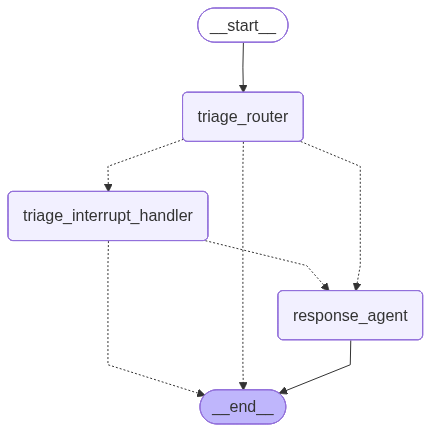

In [20]:
from email_assistant.utils import show_graph

# Conditional edge function
def should_continue(state: State, store: BaseStore) -> Literal["interrupt_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes - with store parameter
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow with store and checkpointer
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
)

email_assistant = overall_workflow.compile()
show_graph(email_assistant)

## Testing the agent with memory

Now that we've implemented memory into our email assistant, let's test how the system learns from user feedback and adapts over time. This testing section explores how different types of user interactions create distinct memory updates that improve the assistant's future performance.

The key questions we're answering through these tests:
1. How does the system capture and store user preferences?
2. How do these stored preferences affect future decisions?
3. What patterns of interaction lead to which types of memory updates?

First, let's build a helper function to display memory content so we can track how it evolves throughout our tests:

In [19]:
import uuid 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command
from langgraph.store.memory import InMemoryStore

# Helper function to display memory content
def display_memory_content(store, namespace=None):
    # Display current memory content for all namespaces
    print("\n======= CURRENT MEMORY CONTENT =======")
    if namespace:
        memory = store.get(namespace, "user_preferences")
        if memory:
            print(f"\n--- {namespace[1]} ---")
            print(memory.value)
        else:
            print(f"\n--- {namespace[1]} ---")
            print("No memory found")
    else:
        for namespace in [
            ("email_assistant", "triage_preferences"),
            ("email_assistant", "response_preferences"),
            ("email_assistant", "cal_preferences"),
            ("email_assistant", "background")
        ]:
            memory = store.get(namespace, "user_preferences")
            if memory:
                print(f"\n--- {namespace[1]} ---")
                print(memory.value)
            else:
                print(f"\n--- {namespace[1]} ---")
                print("No memory found")
            print("=======================================\n")

### Accept `write_email` and `schedule_meeting`

Our first test examines what happens when a user accepts the agent's actions without modification. This baseline case helps us understand how the system behaves when no feedback is provided:

1. We'll use the same tax planning email from our previous tests
2. The system will classify it as "RESPOND" and propose scheduling a meeting
3. We'll accept the meeting schedule without changes
4. The agent will generate an email confirming the meeting
5. We'll accept the email without changes

This test demonstrates the default behavior of our memory-enabled system. When a user simply accepts proposed actions, we expect minimal or no memory updates since there's no explicit feedback to learn from. However, the system will still leverage existing memory (if any) when generating its responses.

In [21]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store)

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-12-09', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
-

Accept the `schedule_meeting` tool call

As we examine the initial `schedule_meeting` proposal, note how the system uses existing memory to inform its decisions:

1. The default calendar preferences show a preference for 30-minute meetings, though the email requests 45 minutes
2. The agent still proposes a 45-minute meeting, respecting the sender's specific request
3. We accept this proposal without modification to see if simple acceptance triggers any memory updates

After running this step, we'll check the memory contents to confirm whether acceptance alone leads to memory updates. Simple acceptance represents the baseline user experience - the system works as intended without requiring adjustments.

In [22]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I am available on Tuesday, December 9th at 2:00 PM for a 45-minute call to discuss tax planning strategies. I have scheduled the meeting accordingly.\n\nLooking forward to your suggestions.\n\nBest regards,\nLance'}}


Accept the `write_email` tool call

Now we'll accept the email draft that confirms the meeting scheduling:

1. The email draft is generated with knowledge of our calendar preferences
2. It includes details about the meeting time, duration, and purpose
3. We'll accept it without changes to complete the baseline test case

After accepting, we'll check all memory stores to see if any updates occurred. As expected, simply accepting the agent's proposals doesn't provide strong learning signals - there's no clear feedback about what the user likes or dislikes about the agent's approach.

The trace link shows the complete workflow execution, where we can see that the memory is used in the LLM call for response generation, but no memory updates occur, which is the expected behavior for simple acceptances.

In [23]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting the write_email tool call
display_memory_content(store)


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_ArJcHHtYihmrCkKGXE6c3NKE)
 Call ID: call_ArJcHHtYihmrCkKGXE6c3NKE
  Args:
    done: True

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails

We can look at the full messages, and the trace: 

https://smith.langchain.com/public/86ff6474-29fe-452e-8829-b05a91b458eb/r

You'll notice that memory is used in the LLM call to respond. 

But the memory store is *not* updated, because we haven't added any feedback via HITL.

In [24]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_GtjpVZzCTinn3rDyq9wmoKye)
 Call ID: call_GtjpVZzCTinn3rDyq9wmoKye
  Args:
    day: 2025-12-09
  check_calendar_availability (call_hruQ9AtHsdb6LDyCuUWdoNuw)
 Call ID: call_hruQ9AtHsdb6LDyCuUWdoNuw
  Args:
    day: 2025-12-11
================================= Tool Message =================================

Ava

### Edit `write_email` and `schedule_meeting`

This test explores how the system learns from direct edits to its proposed actions. When users modify the agent's suggestions, it creates clear, specific learning signals about their preferences:

1. We'll use the same tax planning email as before
2. When the agent proposes a 45-minute meeting, we'll edit it to:
   - Change the duration to 30 minutes (matching our stored preference)
   - Make the subject line more concise
3. When the agent drafts an email, we'll edit it to be:
   - Shorter and less formal
   - Structured differently

Edits provide the most explicit feedback about user preferences, letting the system learn exactly what changes are desired. We expect to see specific, targeted updates to our memory stores that reflect these edits.

In [25]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store,("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-12-09', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

30 minute meetings are preferred, but 15 minute meetings are also acceptable.



Edit the `schedule_meeting` tool call

When we edit the meeting proposal, we're providing direct, explicit feedback about our preferences. This creates a significant learning opportunity for the system:

1. The agent initially proposes a 45-minute meeting (the duration requested in the email)
2. We edit it to 30 minutes and simplify the subject from "Tax Planning Strategies Discussion" to "Tax Planning Discussion"
3. This creates clear, specific feedback about our time preferences and naming conventions

After the edit, we'll check the calendar preferences memory store to see how it's updated. The memory update should capture both:
- Our preference for shorter 30-minute meetings
- Our preference for more concise meeting subjects

The trace reveals the precise memory update logic, showing how the system analyzes the difference between its proposal and our edits to extract meaningful patterns and preferences. We can see the detailed justification for each memory update, ensuring transparency in the learning process.

In [26]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30, # Changed from 45 to 30
    "preferred_day": "2025-04-22",
    "start_time": 14 
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing schedule_meeting
print("\nChecking memory after editing schedule_meeting:")
display_memory_content(store,("email_assistant", "cal_preferences"))


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out regarding tax planning strategies. I am available next week on Tuesday or Thursday afternoon. I have scheduled a 30-minute call for Tuesday, December 9th at 2:00 PM to discuss your suggestions and review potential savings opportunities. If you need a longer slot or prefer Thursday instead, please let me know and I can adjust accordingly.\n\nLooking forward to our discussion.\n\nBest regards,\nLance'}}

Checking memory after editing schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

30 minute meetings are preferred, but 15 minute meetings are also acceptable.
45 minute meetings are not preferred.



```
{'preferences': '\n30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n'}
```

```
{'preferences': "30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n\nUser prefers 30 minute meetings over longer durations such as 45 minutes. When scheduling, default to 30 minutes unless otherwise specified. Subject lines should be concise (e.g., 'Tax Planning Discussion' instead of 'Tax Planning Strategies Discussion')."}
```

Looking at the memory after editing the calendar invitation, we can see that it's been updated:

1. The system has identified that we prefer 30-minute meetings over longer durations
2. It's also captured our preference for concise meeting subjects

What's particularly impressive about this memory update is:
- It doesn't just record our specific edit, but generalizes to a broader preference pattern
- It preserves all existing memory content while adding the new information
- It extracts multiple preference signals from a single edit interaction

Now, let's edit the email draft to see how the system captures different types of communication preferences:

In [27]:
display_memory_content(store,("email_assistant", "response_preferences"))
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Thanks! I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing write_email
print("\nChecking memory after editing write_email:")
display_memory_content(store,("email_assistant", "response_preferences"))


======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
- Explicitly mention reviewing these materials before or durin

Our email edit reveals even more sophisticated learning capabilities:

1. We've dramatically shortened and simplified the email content
2. We've changed the tone to be more casual
3. We've added a question asking for confirmation rather than assuming the time works
4. We've slightly altered the meeting details (day and time)

Looking at the updated memory, we can see that the system has extracted a key insight about our communication style:

```
When scheduling a meeting, ask the recipient to confirm if the proposed time works for them, rather than assuming and stating the meeting is already scheduled.
```

This demonstrates the system's ability to:
- Analyze our edit not just at a superficial level, but to understand intent
- Extract generalizable principles from specific examples
- Preserve all existing guidance while adding new insights
- Maintain the organization and structure of the memory

These targeted, high-quality memory updates will improve all future interactions without requiring repeated corrections.

In [28]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_bBREjpGOKgY6Bw50BYSPUOQf)
 Call ID: call_bBREjpGOKgY6Bw50BYSPUOQf
  Args:
    day: 2025-12-09
  check_calendar_availability (call_OQvOeE9GVkBzVXPIKfU3ZdhA)
 Call ID: call_OQvOeE9GVkBzVXPIKfU3ZdhA
  Args:
    day: 2025-12-11
================================= Tool Message =================================

Ava

### Respond (with feedback) `write_email` and `schedule_meeting`

Our final test set explores the "response" feedback pattern - providing guidance without directly editing or accepting. This conversational feedback mechanism offers a middle ground between acceptance and editing:

1. First, we'll test feedback for meeting scheduling by requesting:
   - Shorter duration (30 minutes instead of 45)
   - Afternoon meeting times (after 2pm)
   
2. Next, we'll test feedback for email drafting by requesting:
   - Shorter, less formal language
   - A specific closing statement about looking forward to the meeting
   
3. Finally, we'll test feedback for questions by providing:
   - A direct answer with additional context
   - Specific preferences (brunch location, time)

This natural language feedback approach lets users guide the assistant without having to do the work themselves. We expect to see detailed memory updates that extract the general principles from our specific feedback.

In [29]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt 
display_memory_content(store, ("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-12-09', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

30 minute meetings are preferred, but 15 minute meetings are also acceptable.



Provide feedback for the `schedule_meeting` tool call

Instead of directly editing the meeting proposal or simply accepting it, we'll provide natural language feedback:

1. We request a 30-minute meeting instead of 45 minutes
2. We express a preference for afternoon meetings after 2pm
3. The system must interpret this feedback and generate a new proposal

This conversational approach is often more natural and efficient than direct editing, especially for mobile users or those who prefer to give high-level direction rather than detailed edits.

After providing feedback, we'll examine the calendar preferences memory to see how this natural language guidance is captured. We expect to see the system extract both the meeting duration and time-of-day preferences as general principles.

In [30]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for schedule_meeting
print("\nChecking memory after providing feedback for schedule_meeting:")
display_memory_content(store, ("email_assistant", "cal_preferences"))


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-12-09', 'start_time': 14}}

Checking memory after providing feedback for schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
30 minute meetings are preferred, but 15 minute meetings are also acceptable.
Meetings should be scheduled for 30 minutes unless otherwise specified.
Afternoon meetings after 2pm are preferred.


Our memory check after providing feedback shows an elegantly simple calendar preference update:

```
30 minute meetings are preferred, but 15 minute meetings are also acceptable.
Afternoon meetings after 2pm are preferred.
```

The system has:
1. Captured both aspects of our feedback (duration and time of day)
2. Preserved the existing preference about 15-minute meetings
3. Added our preference for afternoon meetings after 2pm as a new line
4. Kept the format clean and readable

This natural language feedback mechanism creates the same quality of memory updates as direct editing but requires less effort from the user. The system is able to extract structured preferences from unstructured feedback, showing its ability to learn from conversational interactions.

Let's accept this revised meeting proposal and move to the email draft:

In [31]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting schedule_meeting after feedback
print("\nChecking memory after accepting schedule_meeting after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I’ve scheduled a 30-minute call for us to discuss tax planning strategies on Tuesday, December 9th at 2:00 PM. If you need a longer discussion or would prefer a different time, please let me know.\n\nLooking forward to your suggestions.\n\nBest regards,\nLance'}}

Checking memory after accepting schedule_meeting after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more 

Now provide feedback for the `write_email` tool call

Similar to our meeting feedback, we'll now provide natural language guidance for the email draft:

1. We request "shorter and less formal" language - a style preference
2. We ask for a specific closing statement about looking forward to the meeting
3. The system must interpret this guidance and rewrite the email accordingly

After providing this feedback, we'll check the response preferences memory to see how these style and structure preferences are captured. We expect to see generalizable guidelines about email brevity, formality, and closing statements added to our preference profile.

In [32]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for write_email
print("\nChecking memory after providing feedback for write_email:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nI've set up a 30-minute call for us on Tuesday, December 9th at 2:00 PM to go over tax planning strategies. Let me know if you need more time or want to adjust the slot.\n\nLooking forward to our chat!\n\nThanks,\nLance"}}

Checking memory after providing feedback for write_email:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conferenc

The memory update after our email feedback shows highly sophisticated learning about both meeting scheduling and email writing preferences:

1. The system has added a complete new section to the response preferences entitled "When writing email responses" with two key preferences:
   - "Favor shorter and less formal language when possible, unless the context requires formality"
   - "Include a closing statement expressing that you look forward to the meeting or conversation when confirming appointments"

2. It has also added a new bullet point to the "When responding to meeting scheduling requests" section:
   - "When scheduling meetings, prefer afternoon times after 2pm when possible, and default to 30-minute durations unless otherwise specified"

This demonstrates the system's ability to:
- Organize learned preferences into appropriate categories
- Extract multiple insights from a single feedback instance
- Apply meeting preferences to both calendar and email contexts
- Capture nuance with appropriate qualifiers ("when possible," "unless otherwise specified")
- Maintain the hierarchical structure of the memory

The resulting email shows all these preferences applied: it's shorter, less formal, includes a closing statement about looking forward to the chat, and correctly references the 30-minute meeting time.

In [33]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting write_email after feedback
print("\nChecking memory after accepting write_email after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the write_email tool call...

Checking memory after accepting write_email after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or

Look at the full message history.

In [ ]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

## Local Deployment

You can find this graph with memory integration in the `src/email_assistant` directory:

* `src/email_assistant/email_assistant_hitl_memory.py`

Email to test: 
```
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}
```

As before, if you go to [dev.agentinbox.ai](https://dev.agentinbox.ai/), you can easily connect to the graph:

   * Graph name: the name from the `langgraph.json` file (`email_assistant_hitl_memory`)
   * Graph URL: `http://127.0.0.1:2024/`

![inbox](img/agent-inbox-edit.png)

The Memory tab in LangGraph Studio offers a real-time view of how your preferences are being captured and updated with each interaction:

![studio-img](img/memory-studio.png)

Through continued use, the system becomes increasingly personalized:
- It learns which emails you want to respond to, be notified about, or ignore
- It adapts to your communication style preferences
- It remembers your scheduling preferences
- It refines its understanding with each interaction

This combination of HITL and memory creates a system that balances automation with control - handling routine tasks automatically while learning from your feedback to become more aligned with your preferences over time.

## Hosted Deployment with Gmail Tools

If you want to actually run this on your own email, you can deploy the graph with Gmail tools. 

Set up your Gmail credentials [following here](https://github.com/langchain-ai/agents-from-scratch/blob/main/src/email_assistant/tools/gmail/README.md).

There is a graph set up with Gmail tools:

```shell
python src/email_assistant/email_assistant_hitl_memory_gmail.py
```

[One of the deployment options is `hosted`](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options), and you can simply connect the deployed graph URL to the Agent Inbox as done with the local deployment.

## Improving Memory 

Our current memory schema and updating is extremely simple: 

* Our schema is a string
* We always overwrite the existing memory with a new string
 
The store can be easily [configured for semantic search](https://langchain-ai.github.io/langgraph/cloud/deployment/semantic_search/) over a collection of memories. 

Also consider using [LangMem](https://langchain-ai.github.io/langmem/) for more advanced memory management.